In [1]:
# libraries for initial data analysis
import os
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Goals
- Create a model that estimates the purchase price of gas at any date in the past and extrapolate it for one year into the future
- Take a date as an input and return a price estimate

# Initial thoughts
- Months of the year for seasonal trends
- What factors cause the price of natural gas to vary?
- Exploratory data analysis
- Try simple regressors first, then more complex techniques


In [2]:
# reading the data
root = os.getcwd()
price_data = pd.read_csv(os.path.join(root, 'Nat_Gas.csv'))

In [4]:
price_data.loc['10/31/20']

KeyError: '10/31/20'

In [3]:
# checking the data
price_data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [755]:
# initial overview of the data
price_data.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [5]:
# Converting the date strings into datetime format
price_data['Dates'] = pd.to_datetime(price_data['Dates'])

C:\Users\johnn\AppData\Local\Temp\ipykernel_28120\1569050736.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_data['Dates'] = pd.to_datetime(price_data['Dates'])


In [19]:
price_data['Dates']

dtype('<M8[ns]')

In [26]:
test_date = datetime.strptime('2020-10-31', '%Y-%m-%d')
price_data['Prices'][price_data['Dates'] == test_date]

0    10.1
Name: Prices, dtype: float64

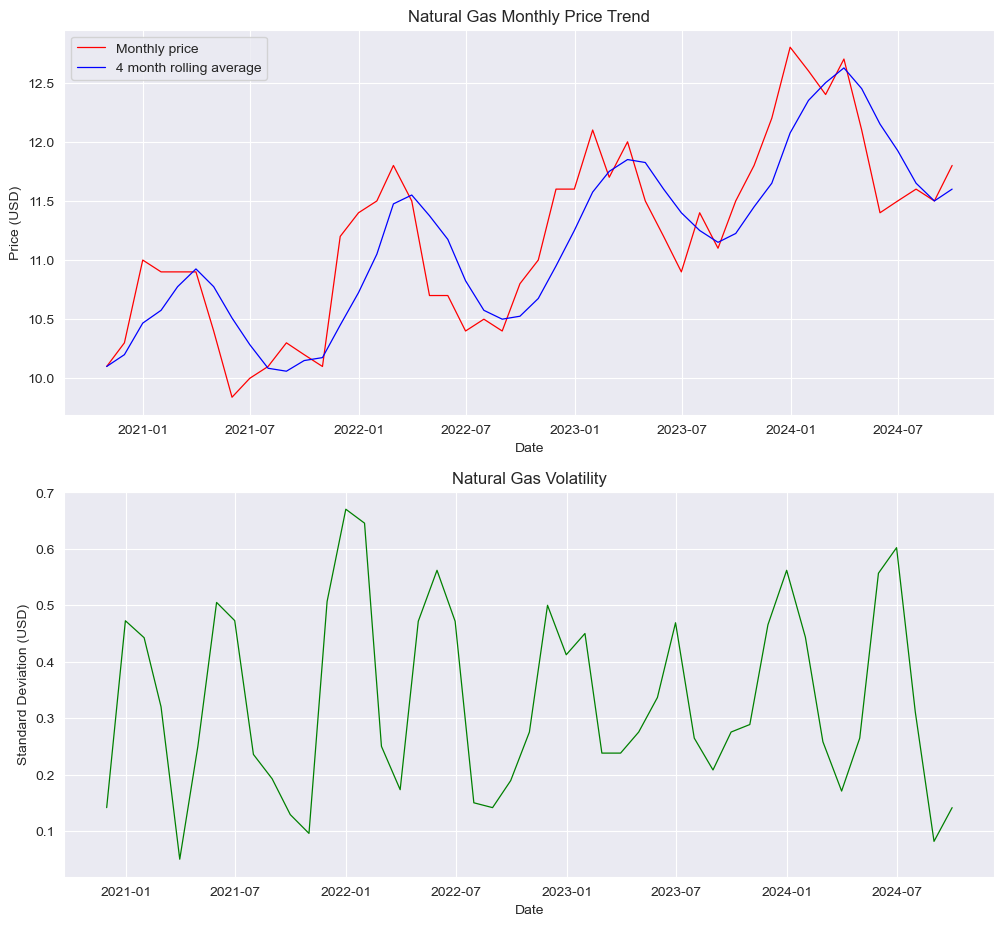

In [757]:
dates = price_data['Dates']
price = price_data['Prices']
window_size = 4  # moving window period in months

# quarterly rolling average
rolling_avg = price.rolling(window_size, min_periods=1).mean()

# quarterly standard deviation
rolling_std_dev = price.rolling(window_size, min_periods=1).std()

# visualisation of the price data
fig, ax1 = plt.subplots(2, 1, figsize=(12, 11))
ax1[0].plot(dates, price, label='Monthly price', color='Red', linewidth=0.9)
ax1[0].plot(dates, rolling_avg, label='4 month rolling average', color='Blue', linewidth=0.9)
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Price (USD)')
ax1[0].set_title('Natural Gas Monthly Price Trend')
ax1[0].legend()
ax1[0].grid(True)

# Rolling standard deviation to identify volatile periods
ax1[1].plot(dates, rolling_std_dev, label='4 month rolling standard deviation', color='Green', linewidth=0.9)
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('Standard Deviation (USD)')
ax1[1].set_title('Natural Gas Volatility')
ax1[1].grid(True)


From a first look, there seems to be some seasonality and a clear upwards trend so we will first perform a time series decomposition to quantify seasonality, trend and noise.

In [758]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [759]:
# Additive decomposition
decomp_period = 12
decomp_a = seasonal_decompose(price, model='additive', period=decomp_period)
trend_a = decomp_a.trend
seasonal_a = decomp_a.seasonal
resid_a = decomp_a.resid

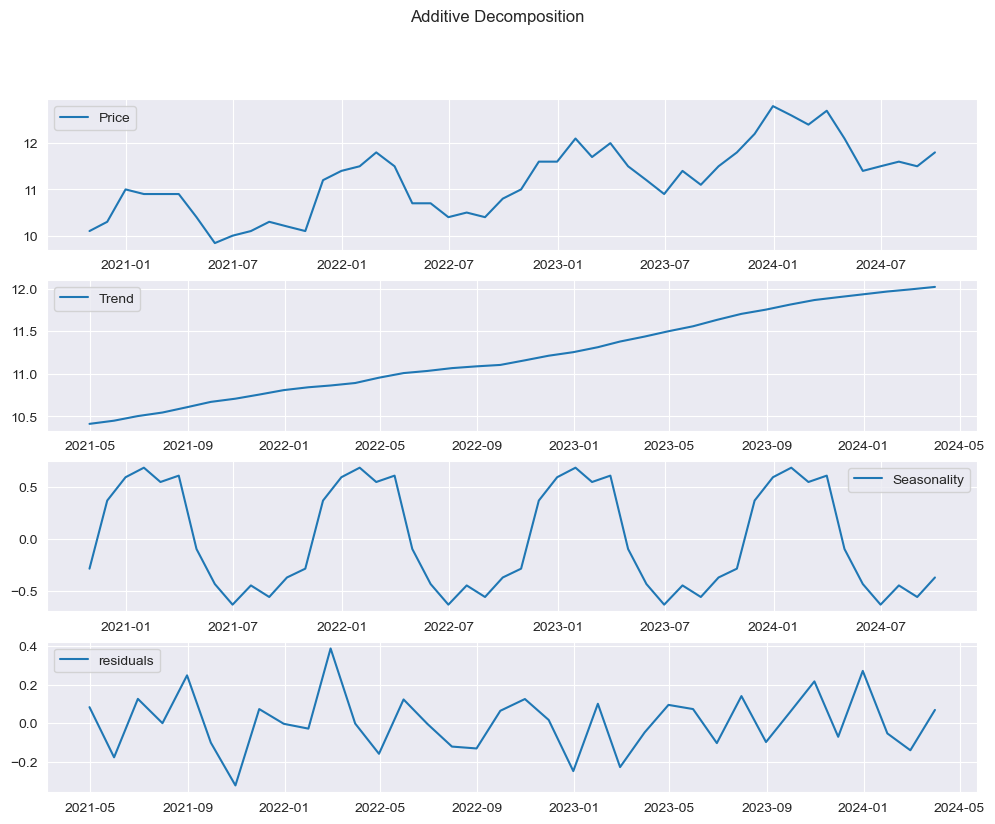

In [760]:
# Plotting the results
plt.figure(figsize=(12,9))
plt.suptitle('Additive Decomposition')

plt.subplot(411)
plt.plot(dates, price, label='Price')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(412)
plt.plot(dates, trend_a, label='Trend')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(413)
plt.plot(dates, seasonal_a, label='Seasonality')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(414)
plt.plot(dates, resid_a, label='residuals')
plt.legend(loc='upper left')
plt.grid(True)

# Predictive models
We will start with basic regressors using the scikit-learn library to learn the trends in the data and create a forecasting model. We need to define features, since the decomposition indicates that:
- there is potential to create a model with the components.
- Look for SARIMAX models and possibly include variables like monthly average temperature, since natural gas usage tends to hike up during winter.
We start with this linear model, and then potentially move onto more complex models like SARIMAX and XGBoost.


In [761]:
from sklearn.linear_model import LinearRegression

# Datetime is not a compatible feature, so we will convert it to ordinal time
price_data['Ordinal Date'] = price_data['Dates'].map(datetime.toordinal)
X = price_data['Ordinal Date'].iloc[decomp_period // 2 : -1 - (decomp_period // 2 - 1)]
y = trend_a.dropna()

# Reshaping into a column vector
X_arr = X.to_numpy().reshape(-1, 1)
y_arr = y.to_numpy().reshape(-1, 1)

linear_model = LinearRegression().fit(X_arr, y_arr)
intercept = linear_model.intercept_
slope = linear_model.coef_[0][0]

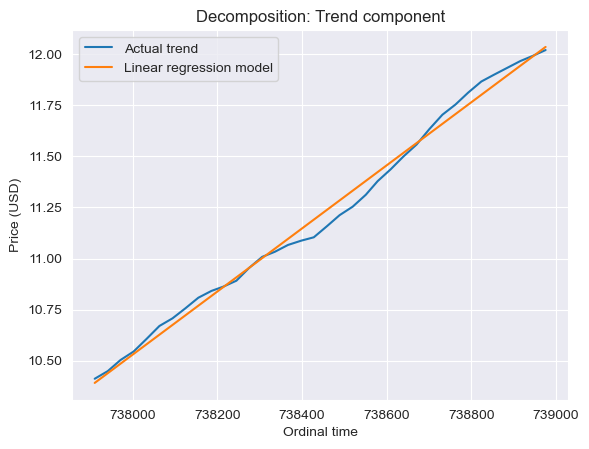

In [762]:
plt.plot(X, y, label='Actual trend')
plt.plot(X, linear_model.predict(X_arr), label='Linear regression model')
plt.legend()
plt.title('Decomposition: Trend component')
plt.xlabel('Ordinal time')
plt.ylabel('Price (USD)')
plt.show()

The linear model seems to capture the trend well. We will now try to capture the seasonality.
Given a specific date within the range, we see the corresponding value in the seasonality and add it to the trend.
This is easy if the data is entirely within range (after extrapolating 1 year ahead) but is slightly more complicated because it becomes an out-of-distribution problem. We can solve this by taking the current seasonality value at the given start date and using the modulo operator to find the next 12 corresponding values in the seasonality by index.

In [982]:
cycle = seasonal_a.iloc[0:13]  # capturing the repeating cycle; each value corresponds to a specific index
look_forward_period = 12  # set to 12 as per the task details

The seasonal component is now complete. The noise component is much harder to capture so we will instead use numpy's random function to generate random noise using the existing amplitude of the noise and just add it on.

In [983]:
# Generating random noise
max_noise = resid_a.max()
min_noise = resid_a.min()

In [990]:
# reminder: date is given in ordinal format
class LinearModel:
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept
    
    @staticmethod
    def gen_noise(max_noise, min_noise):
        np.seed = 1212  # seed for reproducibility
        noise = np.random.uniform(low=min_noise, high=max_noise, size=look_forward_period)
        return noise
    
    # pass in the original dataframe, the seasonal component and the start date
    @staticmethod
    def extrapolate_seasonality(data, seasonal_cycle, start_date, periods=look_forward_period):
        # starting date index
        start_date_idx = pd.Index(data['Dates']).get_loc(start_date)
        
        # getting the corresponding season indices
        seasonality_idx = [i % 12 for i in range(start_date_idx, start_date_idx + look_forward_period)]  
        
        # corresponding season values
        seasonal_values = seasonal_cycle.iloc[seasonality_idx] 
        return seasonal_values

    def predict(self, ordinal_date):
        return self.slope * ordinal_date + self.intercept
    

In [3]:
from datetime import datetime

In [4]:
def date_to_ordinal(date=None, date_format='%Y-%m-%d'):
    # Convert string date to datetime object
    if type(date) is str:
        date_obj = datetime.strptime(date, date_format)
    # Convert datetime object to ordinal date
        ordinal_date = date_obj.toordinal()
        return ordinal_date
    if type(date) is not str:
        return date.toordinal()

In [1035]:
def generate_predictions(start_date, price_data, cycle, slope, intercept, max_noise, min_noise, look_forward_period=look_forward_period):
    # Generate extrapolated dates
    extrapolated_dates = pd.date_range(start_date, periods=look_forward_period, freq='ME')
    
    # Convert extrapolated dates to ordinal form
    ordinal_extrapolated_dates = [date_to_ordinal(date) for date in extrapolated_dates]
    
    # Initialize the linear model
    l_model = LinearModel(slope, intercept)
    
    # Create seasonality values
    extrapolated_seasonality = l_model.extrapolate_seasonality(price_data, cycle, start_date)
    
    # Generate noise component
    noise = l_model.gen_noise(max_noise, min_noise)
    
    # Create the base trend
    base_trend = np.array([l_model.predict(date) for date in ordinal_extrapolated_dates])
    
    # Combine all predictions
    final_predictions = np.add(np.add(base_trend.squeeze(1), extrapolated_seasonality), noise)
    
    # Create a boolean mask to filter the actual prices
    mask = price_data['Dates'].isin(extrapolated_dates)
    truth_price = price_data[mask]['Prices']
    
    return final_predictions, truth_price, mask, extrapolated_dates

# Example usage
start_date = '2023-02-28'
final_predictions, truth_price, mask, extrapolated_dates = generate_predictions(start_date, price_data, cycle, slope, intercept, max_noise, min_noise)

In [1036]:
# MAE and R2 score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def evaluate_model(truth, preds, model_type=''):
    mae = mean_absolute_error(truth, preds)
    mse = mean_squared_error(truth, preds)
    r2 = r2_score(truth, preds)
    print(f"Mean Absolute Error of {model_type} model: {mae}")
    print(f"R2 score of {model_type} model: {r2}")
    print(f"Mean Squared Error of {model_type} model: {mse}")
    return None

In [1037]:
true_count = mask.sum()
if true_count >= look_forward_period:
    evaluate_model(truth_price, final_predictions, 'linear')

Mean Absolute Error of linear model: 0.19769343527833497
R2 score of linear model: 0.7833206246592761
Mean Squared Error of linear model: 0.06829914476885736


In [1038]:
# Plotting the model results and actual data
def plot_results(dates, truth_price, extrapolated_dates, pred_price, 
                 ylabel='Price (USD)', 
                 title='Model performance', 
                 xlabel='Dates',
                 ):
    plt.plot(dates, truth_price, label='Actual price')
    plt.plot(extrapolated_dates, pred_price, label='Predicted price')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


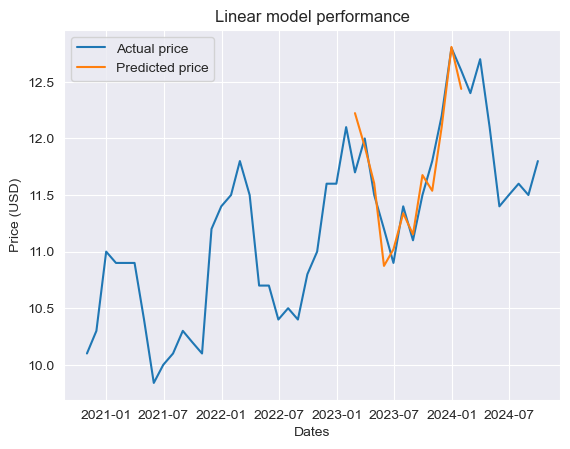

In [1032]:
plot_results(dates, price, extrapolated_dates, final_predictions, title='Linear model performance')